# Bearing  RUL Prediction

In [ ]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote, unquote
from datetime import timedelta
from scipy.fftpack import fft
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## Import libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import trange
import statistics
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed 
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [13]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [27]:
## Set parameters for displaying tag names
table = 'bearing'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [28]:
name

['s1-c1',
 's1-c2',
 's1-c3',
 's1-c4',
 's1-c5',
 's1-c6',
 's1-c7',
 's1-c8',
 's2-c1',
 's2-c2',
 's2-c3',
 's2-c4',
 's3-c1',
 's3-c2',
 's3-c3',
 's3-c4']

## Converting TAG Name Format
* After checking all the Tag Names from the Nasa bearing dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names related to the s1-c5

In [29]:
# Set the desired tag names
tags = ['s1-c5']

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

's1-c5'


## Loading Nasa Bearing Dataset
* Load the train, validation, and test datasets separately when loading the data.
* The example focuses on anomaly detection for the 3rd bearing -> using 's1-c5' as the Tag Name.
* Label all states except for the faulty condition as normal for the labeling process.

In [30]:
# Set the status of each bearing based on time ranges
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

In [31]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data  
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')
    
    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()
    
    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'], format='%Y-%m-%d %H:%M:%S.%f')

    # Group by TIME
    # Round to the nearest second
    filtered_data = df.copy()
    filtered_data.loc[:, 'TIME'] = filtered_data['TIME'].dt.floor('S')
    grouped = filtered_data.groupby('TIME')['s1-c5'].apply(list).reset_index()

    # Split the list into individual columns
    s1_c5_df = pd.DataFrame(grouped['s1-c5'].tolist())

    # Merge with the 'TIME' column
    result_df = pd.concat([grouped[['TIME']], s1_c5_df], axis=1)
    
    # Set labels
    # Assign labels based on abnormal time ranges for each channel data
    result_df['label'] = np.where((result_df['TIME'] >= "2003-11-25 10:57:32") & (result_df['TIME'] <= "2003-11-25 23:39:56"), 1, 0)
    
    result_df = result_df.drop(['TIME'], axis=1)
    
    result_df = result_df.dropna()
    
    return result_df

In [32]:
# Data time loading function
def time_data_load(table, name, start_time, end_time, timeformat):
    
    target = 'TIME'
    
    # Load the data  
    df = pd.read_csv(f"http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?target={target}&table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}")
    
    # Create a dummy value column for resampling
    df['value'] = 0
    
    # Perform resampling
    df['TIME'] = pd.to_datetime(df['TIME'])
    df.set_index('TIME', inplace=True)
    df = df.resample('1s').mean()
    
    # Remove missing values
    df = df.dropna()
    
    # Remove the dummy value column
    df = df.drop(['value'], axis=1)
    
    return df

In [33]:
# Time update function
# Update start and end times based on batch size
# window_size: The period over which data is collected in batches
# step_size: The interval between the data points
def update_time(time_df, start_time, batch_size, window_size, step_size):
    
    # Calculate how many data points need to be loaded
    time = (batch_size * step_size)+ window_size - step_size - 1
    
    # Check the index number of the current time
    # If not found, set to the first index as there is no data for the current time
    try:
        index_now = time_df.index.get_loc(start_time)
    except KeyError:
        index_now = 0
    
    # Set the end time for the batch data based on the current time 
    end_time_ = str(time_df.index[index_now + time] + timedelta(seconds=1))
    
    # Set the index number for the next start time
    index_next = index_now  + step_size
    
    # Set the next start time
    next_start_time_ = str(time_df.index[index_next])
    
    # URL encoding
    start_time_ = quote(start_time)
    end_time_ = quote(end_time_)
    next_start_time_ = quote(next_start_time_)
    
    return start_time_, end_time_, next_start_time_, index_next

In [35]:
# Function to calculate the maximum and minimum values for selected tag names
def set_minmax_value(table, name, start_time_train, end_time_train):
    
    # URL encoding
    start = quote(start_time_train)
    end = quote(end_time_train)
    
    # Load Min, Max data
    df_ = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-scale.tql?table={table}&name={name}&start={start}&end={end}')
    
    # Set Min, Max values
    Min = df_.iloc[:,1:-1].T
    Max = df_.iloc[:,2:].T
    
    return Min, Max  

## Data Preprocessing

* 1 hanning window
* 2 FFT
* 3 MinMax Scaling
* 4 PCA -> Apply during training
* 5 Window sliding

### 1. Hanning Window Setup

In [36]:
# Hanning window function setup 
def set_hanning_window(sample_rate, df):
    
    # Generate Hanning window
    hanning_window = np.hanning(sample_rate)

    # Apply Hanning window to each row
    df_windowed = df.multiply(hanning_window, axis=1)
    
    return df_windowed

### 2. FFT (Fast Fourier Transform) Setup

In [37]:
# FFT transformation function
def change_fft(sample_rate, df):
    # Total number of samples in the signal
    N = sample_rate
    
    fft_results = np.zeros((df.shape[0], N // 2 + 1), dtype=float)
    
    # Apply FFT to each row
    for i in range(df.shape[0]):
        
        # Calculate FFT for each row
        yf = fft(df.iloc[i].values)
        
        # Compute the absolute value of the FFT results and normalize (only the meaningful part)
        fft_results[i] = 2.0 / N * np.abs(yf[:N // 2 + 1])
    
    # Convert FFT results to a DataFrame
    fft_df = pd.DataFrame(fft_results)
    
    return fft_df

### 3. Min-Max Scaling Setup
* Set up a Min-Max Scaler that uses the maximum and minimum values, as the entire dataset is not loaded due to the process concept.

In [38]:
# Definition of the MinMaxScaler class
class MinMaxScaler_custom:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    # Set scale values based on the specified parameters
    def transform(self, X, min_values, max_values):
        X = np.array(X)
        self.min_ = np.array(min_values)
        self.max_ = np.array(max_values)
        
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        scale = (self.max_ - self.min_)
        if np.any(scale == 0):
            raise ValueError("Min and Max values are the same, resulting in a scale of 0.")
        
        return (X - self.min_) / scale
    
    # Normalize data based on calculated scale values
    def fit_transform(self, X, min_values, max_values):
        """Set parameters and then transform X"""
        return self.transform(X, min_values, max_values)

    # Inverse the normalized data back to original values
    def inverse_transform(self, X_scaled):
        """Inverse the transformation and return original values"""
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        X_scaled = np.array(X_scaled)
        scale = (self.max_ - self.min_)
        
        return X_scaled * scale + self.min_

### 5. Window sliding setup
* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [39]:
def make_window(data, window_size, step_size):
    
    # List to store the results of sliding windows
    windows = []
    labels = []
    
    # Apply sliding window
    for i in range(0, data.shape[0] - window_size + 1, step_size):
        window = data.iloc[i:i + window_size, :-1].values
        label_array = data.iloc[i:i + window_size, -1].values
        
        # Set the label to 1 if there is any abnormal value in the label array
        if (label_array == 1).any():
            label = 1  
        else:
            label = 0
        
        windows.append(window)
        labels.append([label])
        
    return windows, labels

## Model Configuration
* Using LSTM AE model.

In [40]:
# LSTM Autoencoder class definition
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, 2*hidden_dim)
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Encoder part
        _, (h, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h[-1])
        
        # Decoder part
        hidden = self.decoder_fc(latent).unsqueeze(0).repeat(x.size(1), 1, 1).permute(1, 0, 2)
        output, _ = self.decoder_lstm(hidden)
        
        return output

In [41]:
# Model configuration parameters

# number of input data columns
input_dim = 31

# LSMT hidden state size
hidden_dim = 15

# layer size
num_layers = 3

# Learning rate
learning_rate = 0.01

# Model configuration
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

LSTMAutoencoder(
  (encoder_lstm): LSTM(31, 15, num_layers=3, batch_first=True)
  (encoder_fc): Linear(in_features=15, out_features=30, bias=True)
  (decoder_fc): Linear(in_features=30, out_features=15, bias=True)
  (decoder_lstm): LSTM(15, 31, num_layers=3, batch_first=True)
)


## Health Index Extranction Model Training

* Save the model with the Best Loss based on the training data during training.

In [42]:
# Model training function
def train(table, name, timeformat, model, batch_size, window_size, step_size, epochs, sample_rate, Min, Max, scaler, pca, time_df_train):
        
    # Initialize training loss
    train_loss = []

    # Initialize Best Loss value
    best_Loss=np.inf

    for epoch in epochs:
        
        model.train()

        running_loss = 0.0
        total_step = 0
        
        # Set initial start time
        start_time_ = str(time_df_train.index[0])
        
        # Set end time
        end_time_train = str(time_df_train.index[-1])

        # Use a while loop to call data 
        while start_time_ < end_time_train:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next= update_time(time_df_train, start_time_, batch_size, window_size, step_size)
            
            # Load batch data 
            data = data_load(table, name, start_time_, end_time_, timeformat)
            
            # Apply hanning window
            data_ = set_hanning_window(sample_rate, data.iloc[:,:-1])
            
            # Apply FFT
            data_  = change_fft(sample_rate, data_ )
            
            # Apply MinMax scaler
            data_ = scaler.fit_transform(data_, Min, Max)
            
            # Apply PCA
            data_ = pca.fit_transform(data_)
            
            # Setting up DataFrame + label
            data_ = pd.DataFrame(data_)
            data_['label'] = data['label'].values

            # Set window 
            windows, labels = make_window(data_ , window_size, step_size)
            
            # Print if the loaded data is empty 
            if len(data_) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(windows) == batch_size:
                
                # Check total batch count  
                total_step = total_step + 1
                
                # Convert data to numpy arrays
                input_data = np.array(windows)

                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()

                # Optimize the optimizer
                optimizer.zero_grad()
                
                # Input to the model
                outputs = model(input_data)
                
                # Calculate loss
                loss = criterion(outputs, input_data)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                # Reset batch data
                windows = []
            
            # Set the next start time   
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + (batch_size * step_size)+ window_size - step_size - 1 >= len(time_df_train):
                break
        
        if total_step > 0:
            train_loss.append(running_loss / total_step)
            print(f'\ntrain loss: {np.mean(train_loss)}')
            
        # best model save     
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Nasa_Bearing_New_Batch_Health_Index.pt')
            print('Save the best model.') 
            
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
               
    return model

In [19]:
########################################### Training Parameter Settings ################################################
# Set tag table name
table = 'bearing'
# Set tag name
name = quote(tags_, safe=":/")
# Set the start time for the train data
start_time_train = '2003-10-22 12:06:24'
# Set the end time for the train data
end_time_train = '2003-11-22 00:00:00'
# Set time format
timeformat = quote('2006-01-02 15:04:05.000000')
# Set batch size
batch_size = 32
# Set window size
window_size = 3
# Set step size -> it must be less than or equal to the window size
step_size = 1
# Set number of epochs
epochs = trange(5, desc='training')
# Set Maximum and Minimum Values 
Min, Max = set_minmax_value(table, name, start_time_train, end_time_train)
# Set sample rate
sample_rate = 20480
# Set Min-Max scaler
scaler = MinMaxScaler_custom()
# Set PCA
# Select principal components that explain 95% of the variance
pca = PCA(n_components=31)
# Load training time list 
time_df_train = time_data_load(table, name, quote(start_time_train), quote(end_time_train), timeformat)

########################################### Proceed with training ################################################
train(table, name, timeformat, model, batch_size, window_size, step_size, epochs, sample_rate, Min, Max, scaler, pca, time_df_train)

training:   0%|          | 0/5 [00:00<?, ?it/s]


train loss: 1.1741458328951531e-05
Save the best model.

train loss: 8.738441371835842e-06
Save the best model.

train loss: 7.739206539867969e-06
Save the best model.

train loss: 7.239504567510633e-06
Save the best model.

train loss: 6.937899280818838e-06
Save the best model.


LSTMAutoencoder(
  (encoder_lstm): LSTM(31, 15, num_layers=3, batch_first=True)
  (encoder_fc): Linear(in_features=15, out_features=30, bias=True)
  (decoder_fc): Linear(in_features=30, out_features=15, bias=True)
  (decoder_lstm): LSTM(15, 31, num_layers=3, batch_first=True)
)

# Health Index Predicition

In [44]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

## Health Index Prediction Model Configuration
* Using DLinear model.

In [45]:
## modeling
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - 0.3*moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size

        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:

            trend_output = self.Linear_Trend(trend_init)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [ ]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Window size: How many past data points will be used
# Forecast: How many future data points to forecast
window_size = 10
forecast_size= 5

# Model configuration
model_rul = LTSF_DLinear(
                    window_size=window_size,
                    forecast_size=forecast_size,
                    kernel_size=25,
                    individual=False,
                    feature_size=1
                    ).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_rul.parameters(), lr=lr)

# Check the model architecture
print(model_rul)

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=10, out_features=5, bias=True)
  (Linear_Seasonal): Linear(in_features=10, out_features=5, bias=True)
)


## Health Index Prediction Model Training

* Save the model with the Best Loss based on the training data during training.

In [47]:
# Health Index Extraction function
def Health_Index_Extraction(table, name, timeformat, model, batch_size, window_size, step_size, sample_rate, Min, Max, scaler, pca, time_df_valid):
        
    # Initialize Health_Index
    Health_Index = []

    with torch.no_grad():
        
        model.eval()

        # Set initial start time
        start_time_ = str(time_df_valid.index[0])
        
        # Set end time
        end_time_valid = str(time_df_valid.index[-1])

        # Use a while loop to call data 
        while start_time_ < end_time_valid:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next= update_time(time_df_valid, start_time_, batch_size, window_size, step_size)
            
            # Load batch data 
            data = data_load(table, name, start_time_, end_time_, timeformat)
            
            # Apply hanning window
            data_ = set_hanning_window(sample_rate, data.iloc[:,:-1])
            
            # Apply FFT
            data_  = change_fft(sample_rate, data_ )
            
            # Apply MinMax scaler
            data_ = scaler.fit_transform(data_, Min, Max)
            
            # Apply PCA
            data_ = pca.fit_transform(data_)
            
            # Setting up DataFrame + label
            data_ = pd.DataFrame(data_)
            data_['label'] = data['label'].values

            # Set window 
            windows, labels = make_window(data_ , window_size, step_size)
            
            # Print if the loaded data is empty 
            if len(data_) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(windows) == batch_size:
                
                # Convert data to numpy arrays
                input_data = np.array(windows)

                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()
                
                # Input to the Extraction model
                outputs = model(input_data)
                
                # Calculate loss
                loss = criterion(outputs, input_data)
                
                # append Health Index
                Health_Index.append(loss.item())
                
                # Reset batch data
                windows = []
            
            # Set the next start time   
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + (batch_size * step_size)+ window_size - step_size - 1 >= len(time_df_valid):
                break
            
        # Convert Train_Health_Index to a numpy array
        Health_Index = np.array(Health_Index).reshape(-1, 1)
                
    return Health_Index

In [48]:
def train_RUL(model, Health_Index_Train):
    
    # Set up datasets 
    train_x, train_y = time_slide_df(Health_Index_Train, window_size, forecast_size)

    train_ds = Data(train_x, train_y)

    train_dataloader_ = DataLoader(train_ds, batch_size = 16, shuffle=False)

    # Initialize loss
    train_loss = []
    # Initialize total step
    total_step = len(train_dataloader_)
    # Set number of epochs
    epoch_in = trange(500, desc='training')
    # Initialize best Loss value
    best_Loss= np.inf

    # Start model training
    for epoch in epoch_in:

        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_dataloader_):
            
            data = data.to(device).float()
            target = target.to(device).float()
            
            optimizer.zero_grad()
            
            # Input to the model
            outputs = model(data)

            # Calculate loss
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        train_loss.append(running_loss/total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')

        # Save the best model
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Nasa_Bearing_New_Batch_RUL.pt')
            print('Model saved')
        epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
        
    return model

In [ ]:
########################################### validation Parameter Settings ################################################
# Load the best model
model_ = torch.load(f'./result/Nasa_Bearing_New_Batch_Health_Index.pt') 
# Set the start time for the validation data
start_time_valid = '2003-11-22 00:00:00'
# Set the end time for the validation data
end_time_valid = '2003-11-23 13:00:00'

# Sliding window configuration
# Window size: How many past data points will be used
# Forecast: How many future data points to forecast
window_size = 10
forecast_size= 5

# Load validation time list
time_df_valid = time_data_load(table, name, quote(start_time_valid), quote(end_time_valid), timeformat)

# Set up MinMaxScaler
scaler_ = MinMaxScaler()

# Extraction Health Index
Health_Index_Train = Health_Index_Extraction(table, name, timeformat, model_, batch_size, window_size, step_size, sample_rate, Min, Max, scaler, pca, time_df_valid)

# Apply MinMax Scaling
Health_Index_Train = scaler_.fit_transform(Health_Index_Train)

# Set DataFrame
Health_Index_Train = Health_Index_Train
Health_Index_Train = pd.DataFrame(Health_Index_Train)

########################################### Proceed with validation ################################################
model_RUL = train_RUL(model_rul, Health_Index_Train)

training:   0%|          | 0/500 [00:00<?, ?it/s]


train loss: 0.2037283256649971
Model saved

train loss: 0.17910358868539333
Model saved

train loss: 0.15920767386754353
Model saved

train loss: 0.14300221279263495
Model saved

train loss: 0.12974045619368552
Model saved

train loss: 0.11878316278258959
Model saved

train loss: 0.10963115029569181
Model saved

train loss: 0.10191457960754634
Model saved

train loss: 0.09535777667123412
Model saved

train loss: 0.08974729371257127
Model saved

train loss: 0.08491183432157745
Model saved

train loss: 0.08071155437889199
Model saved

train loss: 0.07703218032391025
Model saved

train loss: 0.07378096191345582
Model saved

train loss: 0.07088321613147855
Model saved

train loss: 0.06827916232869029
Model saved

train loss: 0.06592106935842072
Model saved

train loss: 0.06377078232148455
Model saved

train loss: 0.06179766536837346
Model saved

train loss: 0.059976948681287466
Model saved

train loss: 0.05828843864035749
Model saved

train loss: 0.056715526507998056
Model saved

train lo

## Model Testing

In [50]:
def test_RUL(model, Health_Index_Test):
    
    # Set up datasets 
    Test_x, Test_y = time_slide_df(Health_Index_Test, window_size, forecast_size)

    Test_ds = Data(Test_x, Test_y)

    Test_dataloader_ = DataLoader(Test_ds, batch_size = 16, shuffle=False)

    # Initial settings 
    output_test = []
    target_test = []

    with torch.no_grad():
        model.eval()
        
        for batch_idx, (data, target) in enumerate(Test_dataloader_):
            
            data_t = data.to(device).float()
            target_t = target.to(device).float()

            outputs_t = model(data_t)
            
            output_test.append(outputs_t)
            target_test.append(target_t)
            
    # Combine tensors into one
    combined_tensor_target = torch.cat(target_test, dim=0)
    combined_tensor_pred = torch.cat(output_test, dim=0)

    # Use only the last value of the window
    last_values_target = combined_tensor_target[:,:1].cpu().numpy().reshape(-1, 1)
    last_values_pred = combined_tensor_pred[:,:1].cpu().numpy().reshape(-1, 1)

        
    return last_values_target, last_values_pred

In [59]:
########################################### Test Parameter Settings ################################################
# Load the best model
model_rul = torch.load(f'./result/Nasa_Bearing_New_Batch_RUL.pt') 
# Set the start time for the test data
start_time_test = '2003-11-23 13:00:00'
# Set the end time for the test data
end_time_test = '2003-11-26 00:00:00'
# Load the test time list
time_df_test = time_data_load(table, name, quote(start_time_test), quote(end_time_test), timeformat)

# Extraction Health Index
Health_Index_Test = Health_Index_Extraction(table, name, timeformat, model_, batch_size, window_size, step_size, sample_rate, Min, Max, scaler, pca, time_df_test)

# Apply MinMax Scaling
Health_Index_Test = scaler_.transform(Health_Index_Test)

# Set DataFrame
Health_Index_Test = Health_Index_Test
Health_Index_Test = pd.DataFrame(Health_Index_Test)

######################################## Proceed with testing #############################################
last_values_target, last_values_pred = test_RUL(model_rul, Health_Index_Test)

## Model Performance Evaluation

In [60]:
# Calculate MSE
mse = mean_squared_error(last_values_target, last_values_pred)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(last_values_target, last_values_pred)
print("R² Score:", r2)

Mean Squared Error: 0.097601384
R² Score: 0.9899177196738984


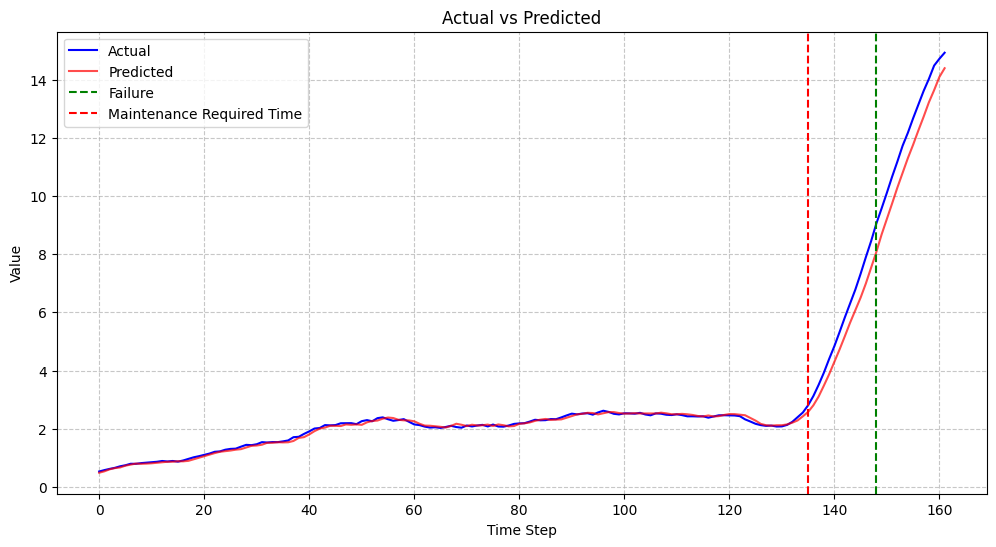

In [ ]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(last_values_target, label='Actual', color='blue')
plt.plot(last_values_pred, label='Predicted', color='red', alpha=0.7)

# Add a vertical line at the 148th position (failure point)
plt.axvline(x=148, color='green', linestyle='--', linewidth=1.5, label='Failure')
# Add a vertical line at the 135th position (maintenance required point)
plt.axvline(x=135, color='red', linestyle='--', linewidth=1.5, label='Maintenance Required Time')

# Set graph title and axis labels
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Display the graph
plt.show()